In [1]:
from discretize import TensorMesh, CylMesh
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
from simpegaem import SimulationAEM
%matplotlib inline

In [2]:
# cell size, number of cells in the x-direction, 
# number of cells in the z-direction and number of padding cells
mesh_type = '2d_cyl'

if mesh_type== '2d_cyl':
    ncx = 10
    csx = 10.
    npadx = 20.
    ncz = 10.
    csz = 5.
    npadz = 18.
    hx = [(csx, ncx), (csx, npadx, 1.3)]
    hz = [(csz, npadz, -1.3), (csz, ncx), (csz, npadz, 1.3)]    
    mesh = CylMesh([hx, 1, hz], x0='00C')
elif mesh_type == '3d_tensor':
    cs, ncx, npad = 10., 9, 8    
    ncy = 1
    ncz = 6
    hx = [(cs, npad, -1.3), (cs, ncx), (cs, npad, 1.3)]
    hy = [(cs, npad, -1.3), (cs, ncy), (cs, npad, 1.3)]    
    hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
    mesh = TensorMesh([hx, hy, hz], 'CCC')
active = mesh.cell_centers[:,2] < 0.
sigma_background = 1./100
sigma_layer = 1./100
sigma = np.ones(mesh.n_cells)*1e-8
sigma[active] = sigma_background
ind_layer = np.logical_and(mesh.cell_centers[:,2]<-100., mesh.cell_centers[:,2]>-200.)
sigma[ind_layer] = sigma_layer
rho = 1./sigma

/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/utils/code_utils.py:148: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)


In [3]:
from matplotlib.colors import LogNorm

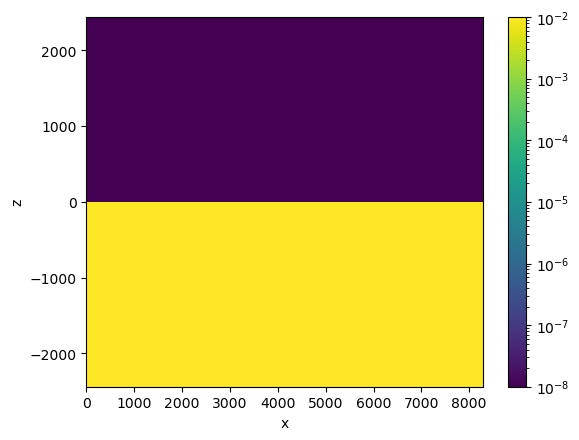

In [4]:
out = mesh.plot_image(sigma, pcolor_opts={'norm':LogNorm()})
plt.colorbar(out[0])

In [5]:
from SimPEG import utils
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps
from pymatsolver import PardisoSolver
# from pymatsolver import Solver

In [6]:
receiver_orientation = "z"                    # "x", "y" or "z"
z_src = 30
x_rx = 10.
z_offset = 0.
receiver_location = np.array([x_rx, 0., z_src+z_offset])
source_location = np.array([0., 0., z_src])
times = np.logspace(np.log10(1e-6), np.log10(1e-2), 31)
rx = tdem.receivers.PointMagneticFluxTimeDerivative(
    receiver_location, times, orientation=receiver_orientation
)
receiver_list = [rx]
src = tdem.sources.MagDipole(
    receiver_list=receiver_list, location=source_location,
    waveform=tdem.sources.StepOffWaveform(), orientation='z'
)

# Survey
source_list = [src]
survey = tdem.Survey(source_list)
# dts = np.diff(np.logspace(-7, -1, 60))
# time_steps = []
# for dt in dts:
#     time_steps.append((dt, 1))

def generate_time_steps(
    n_constant_steps=15, increase_rate=3, start_time_step=5e-7, n_per_step=5
):
    time_steps = []
    for i_step in range(n_constant_steps):
        ht = np.ones(n_per_step) * start_time_step*increase_rate**i_step
        time_steps.append(ht)
    print("t_min:{:.1e}, t_max:{:.1e}".format(start_time_step, np.sum(time_steps)))
    return np.hstack(time_steps)
# dts = np.diff(np.logspace(-7, -1, 60))
# time_steps = []
# for dt in dts:
#     time_steps.append((dt, 1))

time_steps = generate_time_steps(n_constant_steps=15, increase_rate=2, start_time_step=1e-7, n_per_step=5)

simulation_3d = SimulationAEM(
    mesh=mesh,
    survey=survey,
    sigmaMap=maps.IdentityMap(mesh),
    solver=PardisoSolver,
    time_steps=time_steps
)    
data = simulation_3d.dpred(sigma)

t_min:1.0e-07, t_max:1.6e-02


/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/utils/code_utils.py:216: FutureWarning: CylMesh.edgeCurl has been deprecated, please use CylMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/utils/code_utils.py:216: FutureWarning: CylMesh.isSymmetric has been deprecated, please use CylMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/utils/code_utils.py:264: FutureWarning: CylMesh.getInterpolationMat has been deprecated, please use CylMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/cylindrical_mesh.py:1679: FutureWarning: The locType keyword argument has been deprecated, please use location_type. This will be removed in discret

In [7]:
# x = np.linspace(10, 100, 10)
# y = np.zeros_like(x)
# z = np.ones_like(x) * 30.
# Fz = mesh.getInterpolationMat(np.c_[x, y, z], locType='Fz')
# b0 = src.bInitial(prb)
# bz = Fz*b0
# bza = -1./(4*np.pi*x**3) * mu_0
# plt.semilogy(x, -bz/(np.pi/2), 'k-', )
# plt.semilogy(x, -bz, 'k--', )
# plt.semilogy(x, -bza, 'kx')

In [8]:
# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey,
    sigmaMap=maps.IdentityMap(nP=1),
)

# Predict data for a given model
sigma_1d =  np.ones(1) * sigma_background
data_analytic = simulation.dpred(sigma_1d)
data_analytic

array([-1.45108456e-07, -1.05172237e-07, -7.44227958e-08, -5.13277922e-08,
       -3.44554901e-08, -2.24932385e-08, -1.42755650e-08, -8.80996461e-09,
       -5.29053697e-09, -3.09497139e-09, -1.76633327e-09, -9.85087740e-10,
       -5.37835799e-10, -2.88010369e-10, -1.51550454e-10, -7.85016885e-11,
       -4.00973426e-11, -2.02282050e-11, -1.00934771e-11, -4.98821092e-12,
       -2.44448144e-12, -1.18914537e-12, -5.74785469e-13, -2.76280632e-13,
       -1.32161906e-13, -6.29601568e-14, -2.98825471e-14, -1.41402940e-14,
       -6.67398698e-15, -3.14087231e-15, -1.47632394e-15])

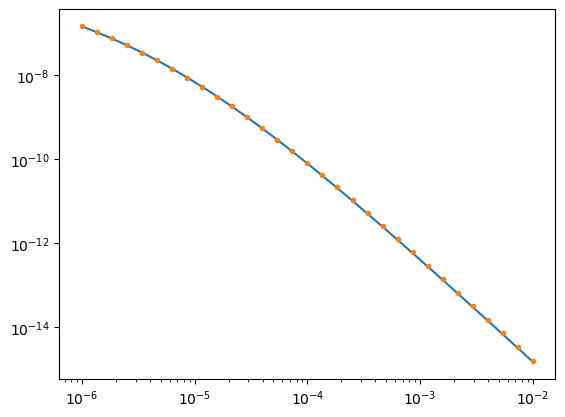

In [9]:
plt.loglog(times, -data_analytic)
plt.loglog(times, -data, '.')

In [10]:
# # %%time
# data_analytic, _, _ = aem_simulation(1./sigma_background, 1./sigma_background, 10, 10)

In [11]:
# plt.loglog(rx.times, -data/(np.pi/2.), 'kx')
# plt.loglog(rx.times, -data_analytic, 'k')
# plt.loglog(prb.times, np.ones(prb.times.size)*1e-11, 'k|')

In [12]:
b0 = src.bInitial(simulation_3d)

In [13]:
from scipy.interpolate import interp1d

In [14]:
def bdf1():
    # Operators
    C = mesh.edgeCurl
    Mfmui = mesh.getFaceInnerProduct(1./mu_0)
    MeSigma = mesh.getEdgeInnerProduct(sigma)
    n_steps = simulation_3d.time_steps.size
    Fz = mesh.getInterpolationMat(rx.locations, locType='Fz')
    eps = 1e-10
    def getA(dt):
        return C.T*Mfmui*C + 1./dt * MeSigma
    dt_0 = 0.
    data_test = np.zeros(simulation_3d.time_steps.size)
    sol_n0 = np.zeros(mesh.nE)
    sol_n1 = np.zeros(mesh.nE)

    for ii in range(n_steps):
        dt = simulation_3d.time_steps[ii]
        A = getA(dt)
        if abs(dt_0-dt) > eps:
            Ainv = simulation_3d.solver(A)
        if ii==0:        
            b0 = src.bInitial(simulation_3d)
            s_e = C.T*Mfmui*b0
            rhs = s_e/dt
        else:
            rhs = MeSigma*sol_n0/dt
        sol_n1 = Ainv*rhs
        data_test[ii] = Fz*(-C*sol_n1)
        dt_0 = dt
        sol_n0 = sol_n1.copy()    
    step_func = interp1d(
        np.log10(simulation_3d.time_mesh.gridCC[:]), data_test
    )
    return step_func(np.log10(rx.times))

In [21]:
def bdf2():
    # Operators
    C = mesh.edgeCurl
    Mfmui = mesh.getFaceInnerProduct(1./mu_0)
    MeSigma = mesh.getEdgeInnerProduct(sigma)
    n_steps = simulation_3d.time_steps.size
    Fz = mesh.getInterpolationMat(rx.locations, locType='Fz')
    eps = 1e-10
    def getA(dt, factor=1.):
        return C.T*Mfmui*C + factor/dt * MeSigma
    dt_0 = 0.
    data_test = np.zeros(simulation_3d.time_steps.size)
    sol_n0 = np.zeros(mesh.nE)
    sol_n1 = np.zeros(mesh.nE)
    sol_n2 = np.zeros(mesh.nE)
    for ii in range(n_steps):
        dt = simulation_3d.time_steps[ii]
        #Factor for BDF2
        factor=3/2.            
        if abs(dt_0-dt) > eps:
            # print (ii, factor)
            A = getA(dt, factor=factor)            
            Ainv = simulation_3d.solver(A)
        if ii==0:        
            b0 = src.bInitial(simulation_3d)
            s_e = C.T*Mfmui*b0
            rhs = factor / dt*s_e
        elif ii==1:
            rhs = -factor/dt*(MeSigma*(-4/3.*sol_n1+1/3.*sol_n0) + 1./3.*s_e)
        else:
            rhs = -factor/dt*(MeSigma*(-4/3.*sol_n1+1/3.*sol_n0))
        sol_n2 = Ainv*rhs
        data_test[ii] = Fz*(-C*sol_n2)
        dt_0 = dt
        sol_n0 = sol_n1.copy()            
        sol_n1 = sol_n2.copy()    
    step_func = interp1d(
        np.log10(simulation_3d.time_mesh.gridCC[:]), data_test
    )
    return step_func(np.log10(rx.times))

In [22]:
temp1 = bdf1()

In [28]:
temp2 = bdf2()

In [29]:
data_analytic

array([-1.45108456e-07, -1.05172237e-07, -7.44227958e-08, -5.13277922e-08,
       -3.44554901e-08, -2.24932385e-08, -1.42755650e-08, -8.80996461e-09,
       -5.29053697e-09, -3.09497139e-09, -1.76633327e-09, -9.85087740e-10,
       -5.37835799e-10, -2.88010369e-10, -1.51550454e-10, -7.85016885e-11,
       -4.00973426e-11, -2.02282050e-11, -1.00934771e-11, -4.98821092e-12,
       -2.44448144e-12, -1.18914537e-12, -5.74785469e-13, -2.76280632e-13,
       -1.32161906e-13, -6.29601568e-14, -2.98825471e-14, -1.41402940e-14,
       -6.67398698e-15, -3.14087231e-15, -1.47632394e-15])

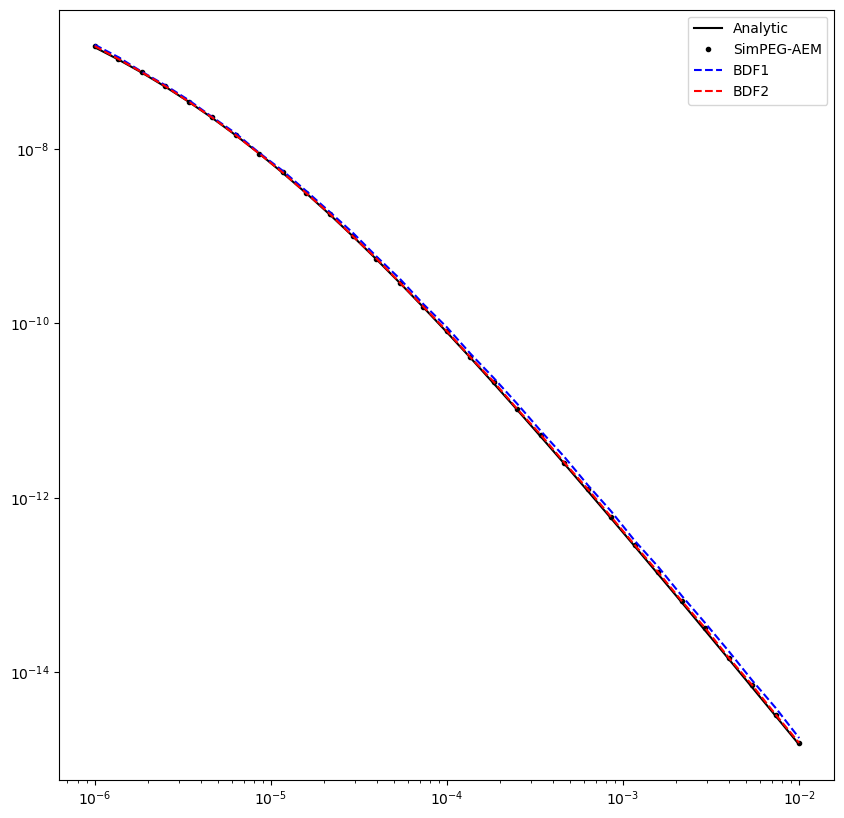

In [30]:
plt.figure(figsize = (10, 10))
plt.loglog(rx.times, -data_analytic, 'k')
plt.loglog(rx.times, -data, 'k.')
plt.loglog(rx.times, -temp1, 'b--')
plt.loglog(rx.times, -temp2, 'r--')
plt.legend(("Analytic", "SimPEG-AEM", "BDF1", "BDF2"))

In [31]:
np.sqrt(abs((data_analytic-temp1)/data_analytic)**2).mean()

0.12500526032888726

In [32]:
np.sqrt(abs((data_analytic-temp2)/data_analytic)**2).mean()

0.028071348629203366

In [33]:
np.sqrt(abs((data_analytic-data)/data_analytic)**2).mean()

0.028071348629203165

In [34]:
import geoana
print (geoana.__version__)

0.4.0


In [35]:
import SimPEG

In [36]:
SimPEG.__version__

'0.17.0'